<div style="display: flex; align-items: center;">
    <div style="display: flex; flex-direction: column; align-items: center;">
        <h1 style="text-align: right;">Centro de Investigación en Matemáticas, A.C.</h1>
        <h2 style="text-align: right;">Reconocimiento de Patrones</h2>
        <h3 style="text-align: right;">Tarea 6. Ejercicio 2. Inciso a)</h3>
    </div>
    <img src="Figures\logoCIMAT11.png" alt="CIMAT Logo" width="200" style="float: left;">
</div>


---

Importamos las librerías que utilizaremos:

In [1]:
import nltk  # Importing the NLTK library, a powerful toolkit for natural language processing.
import string  # Importing the string library for working with strings in Python.
import re  # Importing the regular expression library for pattern matching.
import os  # Importing the os library for interacting with the operating system.
import numpy as np  # Importing NumPy for numerical operations, especially working with arrays.
import pandas as pd  # Importing Pandas for data manipulation and analysis, providing data structures like DataFrames.
import seaborn as sns  # Importing Seaborn for statistical data visualization based on Matplotlib.
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from sklearn.preprocessing import StandardScaler  # Importing StandardScaler from scikit-learn to standardize features by removing the mean and scaling to unit variance.
from sklearn.decomposition import PCA  # Importing Principal Component Analysis (PCA) from scikit-learn for dimensionality reduction techniques.
from collections import Counter  # Importing Counter from the collections library to count occurrences of items in a sequence.
from nltk.corpus import stopwords  # Importing stopwords from the NLTK corpus, which is a list of commonly used words that are often removed from text.
from nltk.stem import SnowballStemmer  # Importing SnowballStemmer from NLTK for stemming text, reducing words to their root form.
from sklearn.feature_extraction.text import CountVectorizer  # Importing CountVectorizer from scikit-learn for converting text data into a matrix of word counts.
from sklearn.model_selection import train_test_split  # Importing train_test_split from scikit-learn for splitting data into training and testing sets.
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder from scikit-learn for converting categorical labels into numerical labels.
from sklearn.svm import SVC  # Importing Support Vector Classifier (SVC) from scikit-learn for classification tasks.
from sklearn.metrics import classification_report, balanced_accuracy_score  # Importing classification_report and balanced_accuracy_score from scikit-learn for evaluating classification models.
from sklearn.linear_model import LogisticRegression  # Importing LogisticRegression from scikit-learn for performing logistic regression.
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Importing DecisionTreeClassifier and plot_tree from scikit-learn for building and visualizing decision trees.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.colors as mcolors
from sklearn import manifold

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Reutilizamos las mismas funciones que en la tarea 5:

In [3]:
# Define preprocessing function
def preprocess(text, stemmer, stop_words):
    # Lowercase the input text to ensure consistent processing.
    text = text.lower()
    # Remove punctuation and numbers from the text.
    # This step helps to remove noise and improves the quality of the processed text.
    text = re.sub(r'[\d]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into individual words or tokens.
    tokens = text.split()
    # Remove stop words and stem the remaining tokens.
    # Stop words are common words (e.g., "the", "a", "is") that are typically removed to focus on important terms.
    # Stemming reduces words to their root form.
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) >= 2]
    return ' '.join(tokens)

In [4]:
def split_into_chapters(text):
    # Split text into chapters based on "Chapter x:" headings
    chapters = []
    current_chapter = []
    for line in text.splitlines():
        # Check if the line is a chapter heading (e.g., "Chapter 1:")
        if re.match(r'^\s*Chapter\s+\d+\s*:', line, re.IGNORECASE):
            # If there's a current chapter, add it to the list of chapters
            if current_chapter:
                chapters.append('\n'.join(current_chapter))
                # Reset the current chapter
                current_chapter = []
        # Add the current line to the current chapter
        current_chapter.append(line)
    # Add the last chapter if there's any remaining content
    if current_chapter:
        chapters.append('\n'.join(current_chapter))
    return chapters


In [5]:

def process_books(directory, k, language):
    """
    Processes a directory of text files, splitting into chapters,
    applying preprocessing, retaining only the k most common words,
    and returning a CountVectorizer object.

    Args:
        directory: Path to the directory with .txt files.
        k: Number of most common words to retain.
        language: Language for stemming and stopwords.

    Returns:
        A tuple (X, vectorizer, chapter_ids) where:
        - X is the matrix representation (chapters x words),
        - vectorizer is the fitted CountVectorizer,
        - chapter_ids is a list like ["book1_chapter1", "book1_chapter2", ...]
    """
    all_texts = []
    chapter_ids = []

    stemmer = SnowballStemmer(language)
    stop_words = set(stopwords.words(language))

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8') as f:
                text = f.read()
                chapters = split_into_chapters(text)
                for idx, chapter in enumerate(chapters, 1):
                    processed_chapter = preprocess(chapter, stemmer, stop_words)
                    all_texts.append(processed_chapter)
                    chapter_ids.append(f"{filename[:-4]}_chapter{idx}")

    # Build vocabulary of the k most common words
    all_word_list = [word for text in all_texts for word in text.split()]
    most_common_words = [word for word, _ in Counter(all_word_list).most_common(k)]

    # Vectorize
    vectorizer = CountVectorizer(min_df=1, vocabulary=most_common_words)
    X = vectorizer.fit_transform(all_texts)

    return X, vectorizer, chapter_ids


In [6]:
X, vectorizer, books = process_books('./books',100,"english")

In [7]:
# Load titles
titulos_df = pd.read_csv('./titulos.csv')

# Create mapping: filename -> title, author
book_mapping = dict(zip(titulos_df['title'], titulos_df['author']))

# Build a DataFrame for chapters
chapter_df = pd.DataFrame({
    'chapter_id': books,   # e.g., 'book1_chapter1'
    'text': list(X.toarray())
})

# Extract book name from chapter_id
chapter_df['book_name'] = chapter_df['chapter_id'].apply(lambda x: re.sub(r'_chapter\d+$', '', x))

# Now map title and author
chapter_df['title'] = chapter_df['book_name']
chapter_df['author'] = chapter_df['title'].map(book_mapping)

# Expand the X matrix into columns
X_dense = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())



In [8]:
# Create a LabelEncoder object to convert categorical author names into numerical values.
label_encoder = LabelEncoder()
# Fit the LabelEncoder to the 'author' column of the DataFrame and transform it into numerical values.
# These numerical values are then stored in the 'y' variable.
y = label_encoder.fit_transform(chapter_df['author'])
# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

Ahora, creamos un autoencoder por una red neuronal de Keras que consiste en tres capas de codificación y tres de decodificación, lo que podemos ver a continuación:

In [9]:
# Build the autoencoder
input_dim = X_scaled.shape[1]  # should be 100

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encode1 = Dense(64, activation='relu')(input_layer)
encode2 = Dense(32, activation='relu')(encode1)
reduced = Dense(2, activation='linear')(encode2)  # final 2D representation

# Decoder
decode1 = Dense(32, activation='relu')(reduced)
decode2 = Dense(64, activation='relu')(decode1)
decoded = Dense(input_dim, activation='linear')(decode2)

# Full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded, name="Autoencoder")

# Encoder model (for 2D representation)
encoder = Model(inputs=input_layer, outputs=reduced)

# Compile and train
autoencoder.compile(optimizer=Adam(learning_rate=1e-3,beta_1=0.5), loss=Huber(delta=1.0))

autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
 dense_3 (Dense)             (None, 32)                96        
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 100)               

Entrenamos la red neuronal con los datos escalados:

In [10]:
autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
17/17 [==============================] - 3s 16ms/step - loss: 0.2529 - val_loss: 0.1916
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.2395 - val_loss: 0.1766
Epoch 3/100
17/17 [==============================] - 0s 8ms/step - loss: 0.2212 - val_loss: 0.1730
Epoch 4/100
17/17 [==============================] - 0s 8ms/step - loss: 0.2061 - val_loss: 0.1711
Epoch 5/100
17/17 [==============================] - 0s 8ms/step - loss: 0.2002 - val_loss: 0.1708
Epoch 6/100
17/17 [==============================] - 0s 8ms/step - loss: 0.1978 - val_loss: 0.1712
Epoch 7/100
17/17 [==============================] - 0s 7ms/step - loss: 0.1997 - val_loss: 0.1703
Epoch 8/100
17/17 [==============================] - 0s 7ms/step - loss: 0.1943 - val_loss: 0.1698
Epoch 9/100
17/17 [==============================] - 0s 7ms/step - loss: 0.1921 - val_loss: 0.1695
Epoch 10/100
17/17 [==============================] - 0s 7ms/step - loss: 0.1957 - val_loss: 0.1686
Epoch 11

Ahora, pasamos los datos por la parte codificadora de la red neuronal:

In [11]:
# Get 2D encoded data
X_encoded = encoder.predict(X_scaled)

19/19 [==============================] - 0s 2ms/step


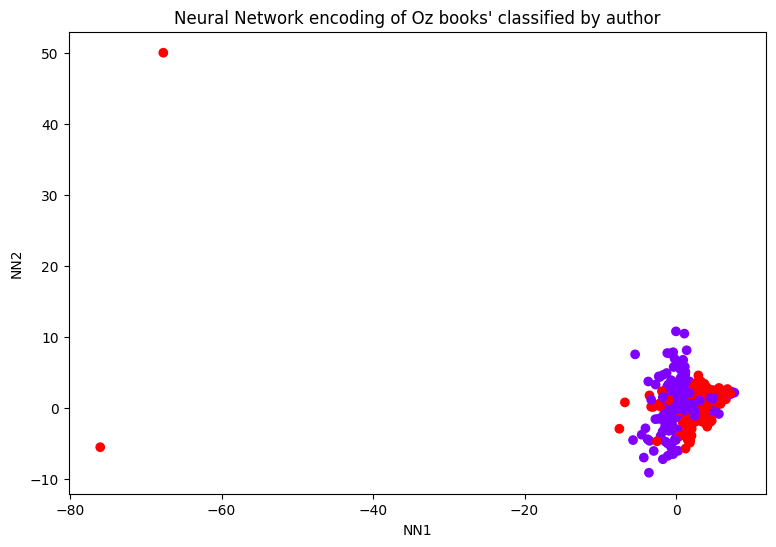

In [12]:
# Create a scatter plot of the data in the Encoder dimensions.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(X_encoded[:,0],X_encoded[:,1], c = y, cmap = 'rainbow')
#plt.xlim(-15, 10)
#plt.ylim(-10,5)
# Add a title to the plot.
plt.title('Neural Network encoding of Oz books\' classified by author')
# Label the x-axis as "NN1" (first Neural Network component)
plt.xlabel("NN{}".format(1))
# Label the y-axis as "NN2" (second Neural Network component)
plt.ylabel("NN{}".format(2))
# Display the plot
plt.show()

In [13]:
# Perform Principal Component Analysis (PCA) to reduce data to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

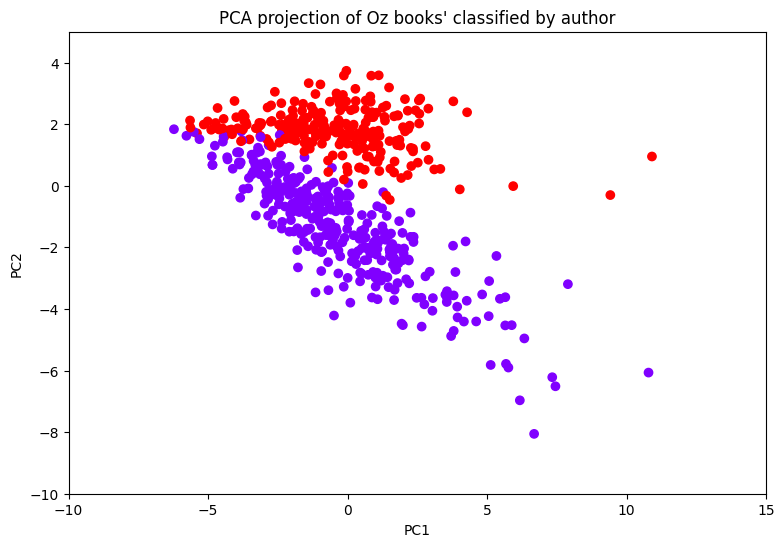

In [14]:
# Create a scatter plot of the data in the first two principal components.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(pca_data[:,0],pca_data[:,1], c = y, cmap = 'rainbow')
plt.xlim(-10, 15)
plt.ylim(-10,5)
# Add a title to the plot.
plt.title('PCA projection of Oz books\' classified by author')
# Label the x-axis as "PC1" (first principal component)
plt.xlabel("PC{}".format(1))
# Label the y-axis as "PC2" (second principal component)
plt.ylabel("PC{}".format(2))
# Display the plot
plt.show()

In [15]:
iso = manifold.Isomap(n_components=2)
X_iso = iso.fit_transform(X_scaled)

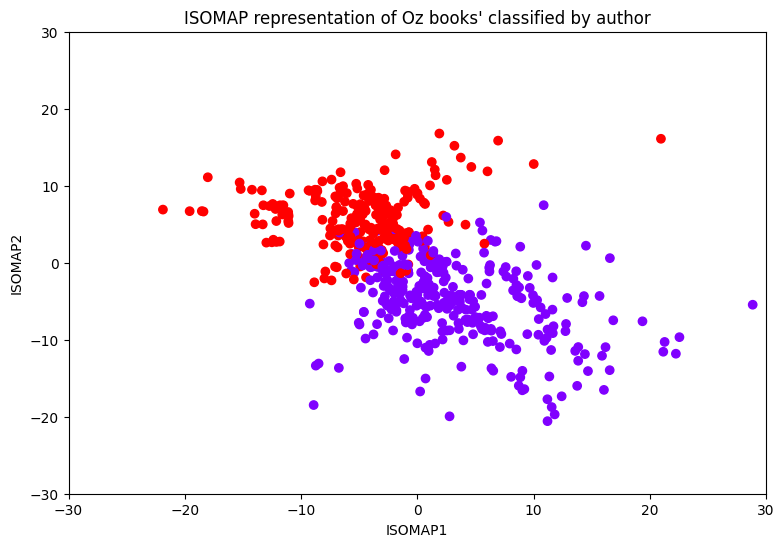

In [16]:
# Create a scatter plot of the data representation via ISOMAP.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(X_iso[:,0],X_iso[:,1], c = y, cmap = 'rainbow')
plt.xlim(-30, 30)
plt.ylim(-30,30)
# Add a title to the plot.
plt.title('ISOMAP representation of Oz books\' classified by author')
# Label the x-axis as "NN1" (first Neural Network component)
plt.xlabel("ISOMAP{}".format(1))
# Label the y-axis as "NN2" (second Neural Network component)
plt.ylabel("ISOMAP{}".format(2))
# Display the plot
plt.show()

In [17]:
tsne = manifold.TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

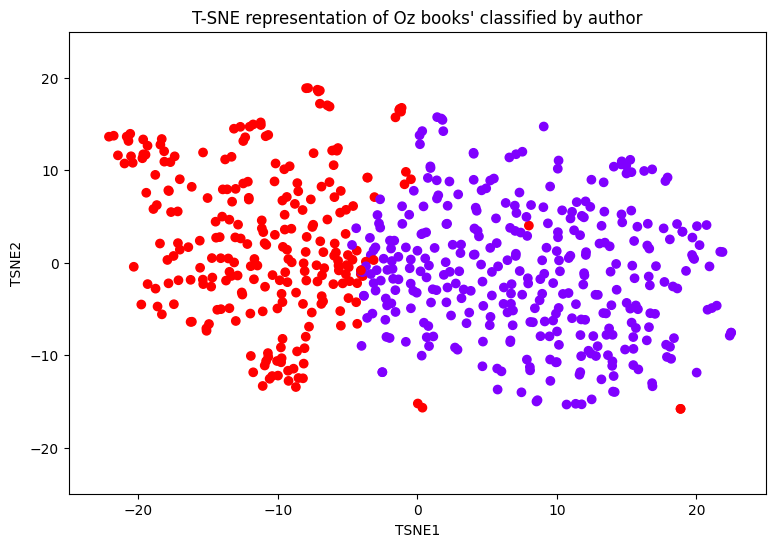

In [18]:
# Create a scatter plot of the data representation via ISOMAP.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = y, cmap = 'rainbow')
plt.xlim(-25, 25)
plt.ylim(-25, 25)
# Add a title to the plot.
plt.title('T-SNE representation of Oz books\' classified by author')
# Label the x-axis as "NN1" (first Neural Network component)
plt.xlabel("TSNE{}".format(1))
# Label the y-axis as "NN2" (second Neural Network component)
plt.ylabel("TSNE{}".format(2))
# Display the plot
plt.show()

En este caso, casi todos los métodos resultan en datos bastante separables. Si acaso, el mejor es T-SNE.

In [ ]:
# Build the autoencoder
input_dim = X_scaled.shape[1]  # should be 100

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encode1 = Dense(64, activation='relu')(input_layer)
encode2 = Dense(32, activation='relu')(encode1)
reduced = Dense(3, activation='linear')(encode2)  # final 3D representation

# Decoder
decode1 = Dense(32, activation='relu')(reduced)
decode2 = Dense(64, activation='relu')(decode1)
decoded = Dense(input_dim, activation='linear')(decode2)

# Full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded, name="Autoencoder-3D")

# Encoder model (for 3D representation)
encoder = Model(inputs=input_layer, outputs=reduced)

# Compile and train
autoencoder.compile(optimizer=Adam(learning_rate=1e-3,beta_1=0.5), loss=Huber(delta=1.0))

autoencoder.summary()

Model: "Autoencoder-3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 64)                6464      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
 dense_9 (Dense)             (None, 32)                128       
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 100)            

Entrenamos la red neuronal con los datos escalados:

In [20]:
autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
17/17 [==============================] - 1s 24ms/step - loss: 0.2499 - val_loss: 0.1844
Epoch 2/100
17/17 [==============================] - 0s 18ms/step - loss: 0.2341 - val_loss: 0.1737
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 0.2180 - val_loss: 0.1716
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 0.2051 - val_loss: 0.1698
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 0.1982 - val_loss: 0.1680
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 0.1931 - val_loss: 0.1660
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.1909 - val_loss: 0.1644
Epoch 8/100
17/17 [==============================] - 0s 6ms/step - loss: 0.1888 - val_loss: 0.1651
Epoch 9/100
17/17 [==============================] - 0s 6ms/step - loss: 0.1920 - val_loss: 0.1642
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: 0.1857 - val_loss: 0.1628
Epoc

Ahora, pasamos los datos por la parte codificadora de la red neuronal:

In [ ]:
# Get 3D encoded data
X_encoded = encoder.predict(X_scaled)

19/19 [==============================] - 0s 2ms/step


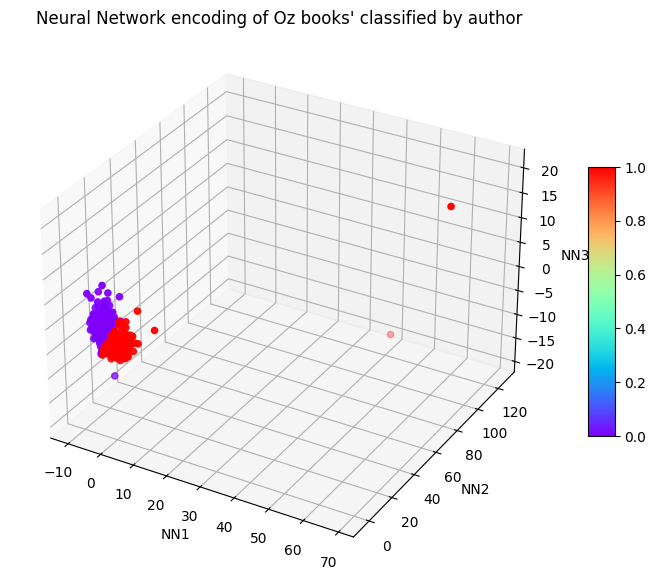

In [22]:
# Create a 3D scatter plot of the data in the encoder dimensions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D encoded points, colored by class labels `y`
sc = ax.scatter(X_encoded[:, 0], X_encoded[:, 1], X_encoded[:, 2], c=y, cmap='rainbow')

# Add axis labels
ax.set_xlabel('NN1')
ax.set_ylabel('NN2')
ax.set_zlabel('NN3')

# Add a title
ax.set_title("Neural Network encoding of Oz books' classified by author")

# Add color bar if desired
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

# Display the plot
plt.show()


In [23]:
# Perform Principal Component Analysis (PCA) to reduce data to 2 dimensions
pca = PCA(n_components=3)
pca_data = pca.fit_transform(X_scaled)

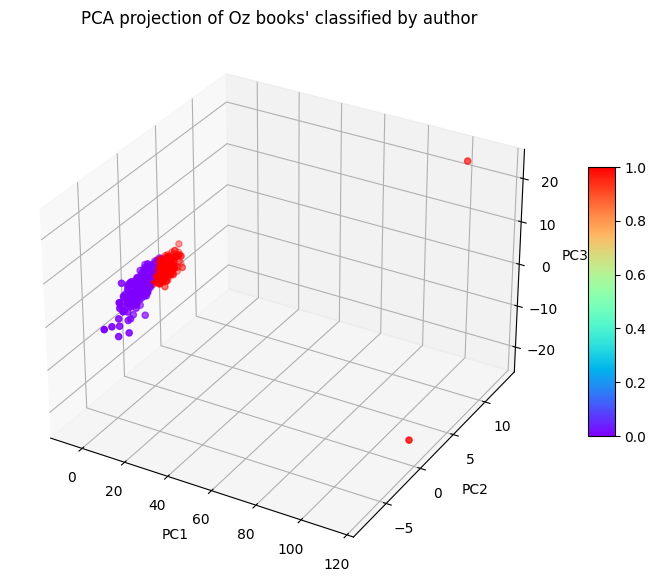

In [24]:
# Create a 3D scatter plot of the data in the encoder dimensions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D encoded points, colored by class labels `y`
sc = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=y, cmap='rainbow')

# Add axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Add a title
ax.set_title('PCA projection of Oz books\' classified by author')

# Add color bar if desired
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

# Display the plot
plt.show()


In [25]:
iso = manifold.Isomap(n_components=3)
X_iso = iso.fit_transform(X_scaled)

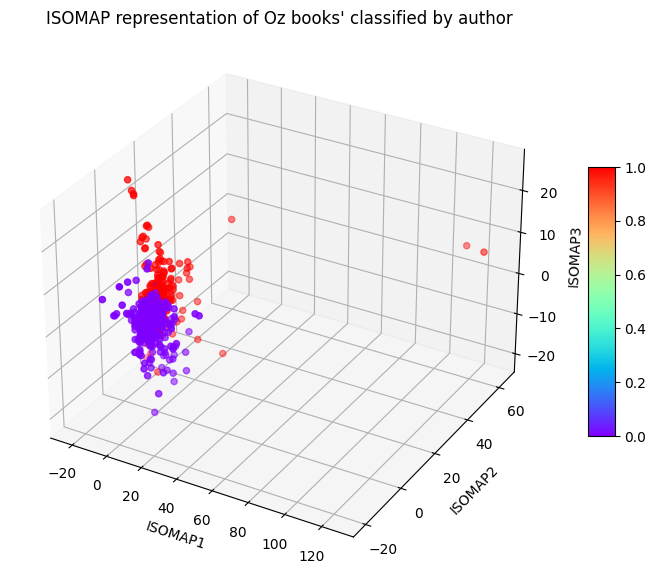

In [26]:
# Create a 3D scatter plot of the data in the encoder dimensions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D encoded points, colored by class labels `y`
sc = ax.scatter(X_iso[:, 0], X_iso[:, 1], X_iso[:, 2], c=y, cmap='rainbow')

# Add axis labels
ax.set_xlabel('ISOMAP1')
ax.set_ylabel('ISOMAP2')
ax.set_zlabel('ISOMAP3')

# Add a title
ax.set_title('ISOMAP representation of Oz books\' classified by author')

# Add color bar if desired
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

# Display the plot
plt.show()

In [27]:
tsne = manifold.TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

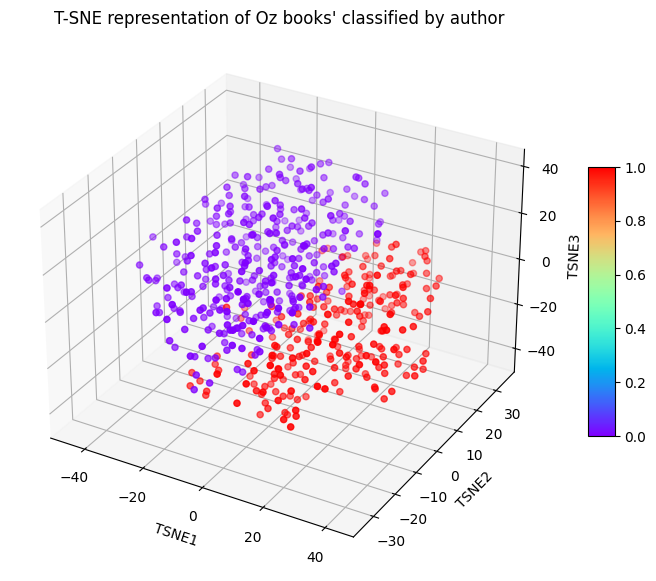

In [28]:
# Create a 3D scatter plot of the data in the encoder dimensions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D encoded points, colored by class labels `y`
sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='rainbow')

# Add axis labels
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')

# Add a title
ax.set_title('T-SNE representation of Oz books\' classified by author')

# Add color bar if desired
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

# Display the plot
plt.show()


Aquí se repite lo anterior, los datos son casi separables en todos los casos, el mejor siendo T-SNE.